#### Problema #1

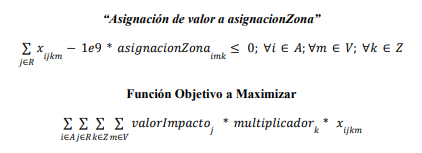

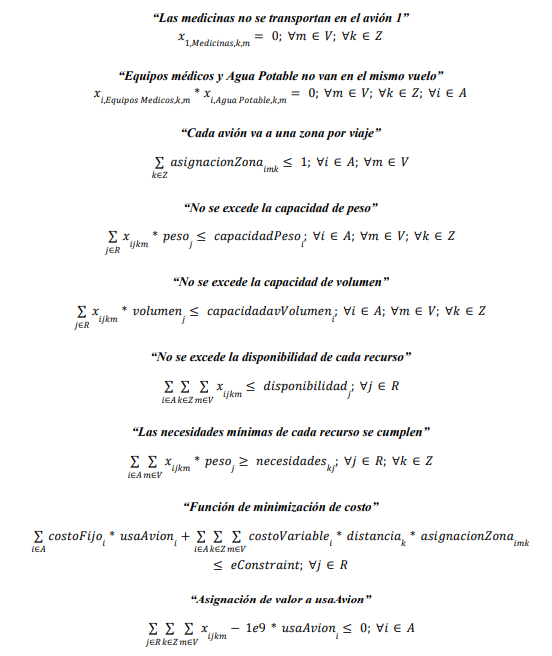

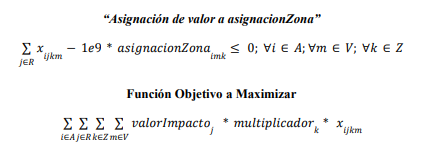

In [ ]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import pandas as pd


def correr_modelo(multiplicador, e, graficar=False):
    R = ["Alimentos Basicos", "Medicinas", "Equipos Medicos", "Agua Potable", "Mantas"]
    A = [1, 2, 3, 4]
    Z = ["A", "B", "C", "D"]
    V = [1, 2]

    valor_impacto = {
        "Alimentos Basicos": 50,
        "Medicinas": 100,
        "Equipos Medicos": 120,
        "Agua Potable": 60,
        "Mantas": 40,
    }
    peso = {
        "Alimentos Basicos": 5,
        "Medicinas": 2,
        "Equipos Medicos": 0.3,
        "Agua Potable": 6,
        "Mantas": 3,
    }
    volumen = {
        "Alimentos Basicos": 3,
        "Medicinas": 1,
        "Equipos Medicos": 0.5,
        "Agua Potable": 4,
        "Mantas": 2,
    }
    disponibilidad = {
        "Alimentos Basicos": 12,
        "Medicinas": 15,
        "Equipos Medicos": 40,
        "Agua Potable": 15,
        "Mantas": 20,
    }

    capacidad_peso = {1: 40, 2: 50, 3: 60, 4: 45}
    capacidad_volumen = {1: 35, 2: 40, 3: 45, 4: 38}
    costo_fijo = {1: 15, 2: 20, 3: 25, 4: 18}
    costo_variable = {1: 0.02, 2: 0.025, 3: 0.03, 4: 0.022}

    distancia = {"A": 800, "B": 1200, "C": 1500, "D": 900}
    poblacion = {"A": 50, "B": 70, "C": 100, "D": 80}

    necesidades = {
        "A": {
            "Alimentos Basicos": 8,
            "Agua Potable": 6,
            "Medicinas": 2,
            "Equipos Medicos": 0.6,
            "Mantas": 3,
        },
        "B": {
            "Alimentos Basicos": 12,
            "Agua Potable": 9,
            "Medicinas": 3,
            "Equipos Medicos": 0.9,
            "Mantas": 5,
        },
        "C": {
            "Alimentos Basicos": 16,
            "Agua Potable": 12,
            "Medicinas": 4,
            "Equipos Medicos": 1.2,
            "Mantas": 7,
        },
        "D": {
            "Alimentos Basicos": 10,
            "Agua Potable": 8,
            "Medicinas": 2,
            "Equipos Medicos": 0.6,
            "Mantas": 4,
        },
    }

    Model = ConcreteModel()

    Model.x = Var(A, R, Z, V, domain=NonNegativeIntegers)
    Model.usa_avion = Var(A, domain=Binary)
    Model.asignacion_zona = Var(A, V, Z, domain=Binary)

    Model.obj = Objective(
        expr=sum(
            valor_impacto[j] * multiplicador[k] * Model.x[i, j, k, m]
            for i in A
            for j in R
            for k in Z
            for m in V
        ),
        sense=maximize,
    )

    Model.res1 = ConstraintList()
    for m in V:
        for k in Z:
            Model.res1.add(expr=Model.x[1, "Medicinas", k, m] == 0)

    Model.res2 = ConstraintList()
    for i in A:
        for k in Z:
            for m in V:
                Model.res2.add(
                    expr=Model.x[i, "Equipos Medicos", k, m]
                    * Model.x[i, "Agua Potable", k, m]
                    == 0
                )

    Model.res4 = ConstraintList()
    for i in A:
        for m in V:
            Model.res4.add(expr=sum(Model.asignacion_zona[i, m, k] for k in Z) <= 1)

    Model.res5 = ConstraintList()
    for i in A:
        for k in Z:
            for m in V:
                Model.res5.add(
                    expr=sum(Model.x[i, j, k, m] * peso[j] for j in R)
                    <= capacidad_peso[i]
                )

    Model.res6 = ConstraintList()
    for i in A:
        for k in Z:
            for m in V:
                Model.res6.add(
                    expr=sum(Model.x[i, j, k, m] * volumen[j] for j in R)
                    <= capacidad_volumen[i]
                )

    Model.res7 = ConstraintList()
    for j in R:
        Model.res7.add(
            expr=sum(Model.x[i, j, k, m] for i in A for k in Z for m in V)
            <= disponibilidad[j]
        )

    Model.res8 = ConstraintList()
    for j in R:
        for k in Z:
            Model.res8.add(
                expr=necesidades[k][j]
                <= sum(Model.x[i, j, k, m] * peso[j] for i in A for m in V)
            )

    Model.res9 = ConstraintList()
    Model.res9.add(
        expr=sum(costo_fijo[i] * Model.usa_avion[i] for i in A)
        + sum(
            costo_variable[i] * distancia[k] * Model.asignacion_zona[i, m, k]
            for i in A
            for k in Z
            for m in V
        )
        <= e
    )

    Model.res10 = ConstraintList()
    for i in A:
        Model.res10.add(
            expr=sum(Model.x[i, j, k, m] for j in R for k in Z for m in V)
            - 1e9 * Model.usa_avion[i]
            <= 0
        )

    Model.res11 = ConstraintList()
    for i in A:
        for m in V:
            for k in Z:
                Model.res11.add(
                    expr=sum(Model.x[i, j, k, m] for j in R)
                    - 1e9 * Model.asignacion_zona[i, m, k]
                    <= 0
                )

    solver = SolverFactory("ipopt")
    solver.solve(Model, tee=False)

    costo_total = sum(costo_fijo[i] * value(Model.usa_avion[i]) for i in A) + sum(
        costo_variable[i] * distancia[k] * value(Model.asignacion_zona[i, m, k])
        for i in A
        for k in Z
        for m in V
    )

    recursos_aviones = {(i, m): {r: 0 for r in R} for i in A for m in V}

    if graficar:
        for i in A:
            for j in R:
                for k in Z:
                    for m in V:
                        cantidad = value(Model.x[i, j, k, m])
                        if cantidad and cantidad > 0.9:
                            recursos_aviones[(i, m)][j] += cantidad

        df = pd.DataFrame(recursos_aviones).T
        df.plot(kind="bar", stacked=True, figsize=(12, 7))
        plt.title("Recursos enviados por avión y vuelo")
        plt.xlabel("(Avión, Vuelo)")
        plt.ylabel("Cantidad")
        plt.legend(title="Recurso")
        plt.tight_layout()
        plt.show()

    return value(Model.obj), costo_total


multiplicador = {"A": 1.2, "B": 1.5, "C": 1.8, "D": 1.4}
e_values = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]

impactos = []
costos = []

for e in e_values:
    impacto, costo = correr_modelo(multiplicador, e)
    impactos.append(impacto)
    costos.append(costo)

plt.figure(figsize=(8, 6))
plt.plot(costos, impactos, "o-", color="blue")
plt.title("Frente de Pareto: Costo vs Impacto")
plt.xlabel("Costo Total Utilizado")
plt.ylabel("Impacto Total (Objetivo)")
plt.grid(True)
plt.show()

correr_modelo(multiplicador, 4500, True)
correr_modelo(multiplicador, 5000, True)

sensibilidad = []

for zona in multiplicador.keys():
    for cambio in [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]:
        multiplicador_mod = multiplicador.copy()
        multiplicador_mod[zona] *= 1 + cambio

        impacto, costo = correr_modelo(multiplicador_mod, 5000)
        sensibilidad.append(
            {
                "Zona modificada": zona,
                "Cambio (%)": cambio * 100,
                "Impacto óptimo": impacto,
                "Costo utilizado": costo,
            }
        )

df_sensibilidad = pd.DataFrame(sensibilidad)
print(df_sensibilidad)


#### Frente de Pareto

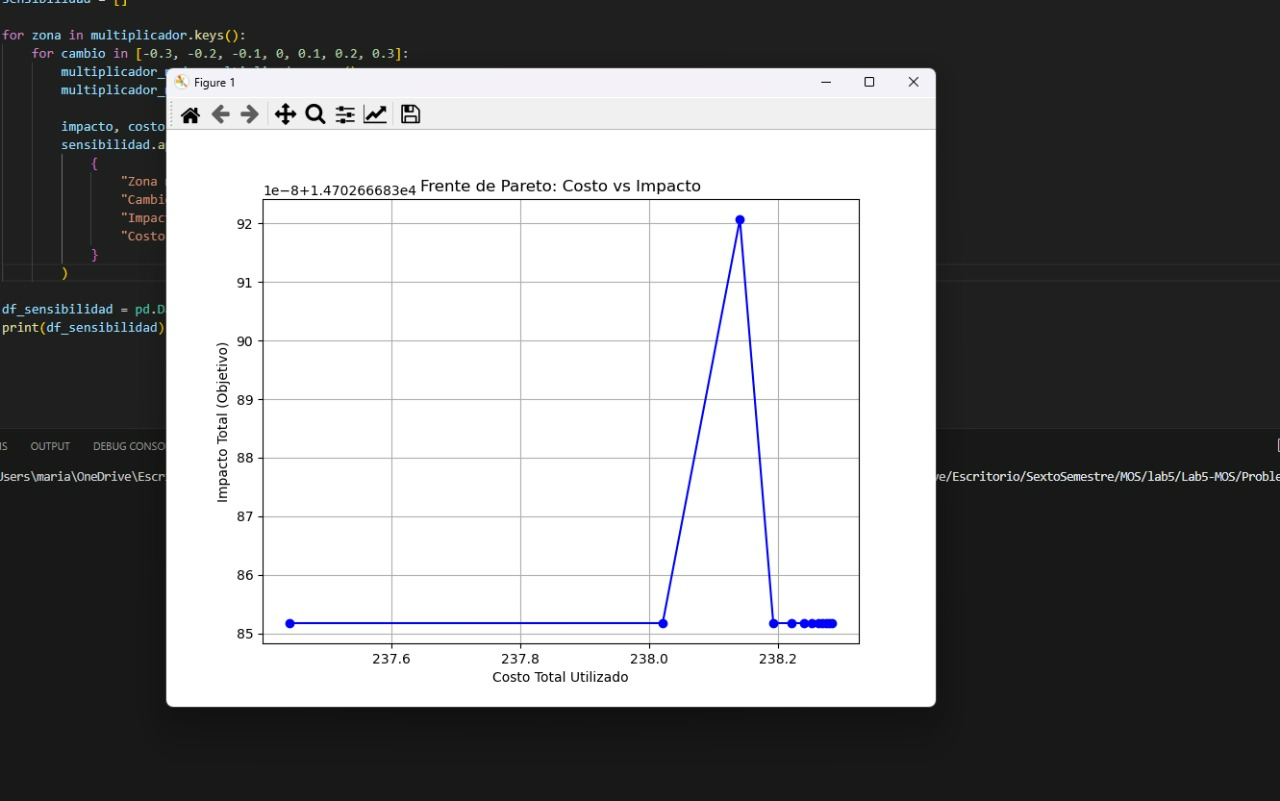

En la grafica se puede observar que el impacto en general es el mismo para todos los puntos evaluados excepto para uno, que tiene un impacto mucho mayor teniendo a la vez un costo menor que la mayoria de los puntos evaluados. Con este punto se logra maximizar el impacto teniendo un costo no tan alto. Por lo tanto este punto representa la solución de compromiso escogida. Cabe resaltar que es subjetiva y debería evaluarse en un contexto real donde la empresa pondere mas adecuadamente la parte financiera.

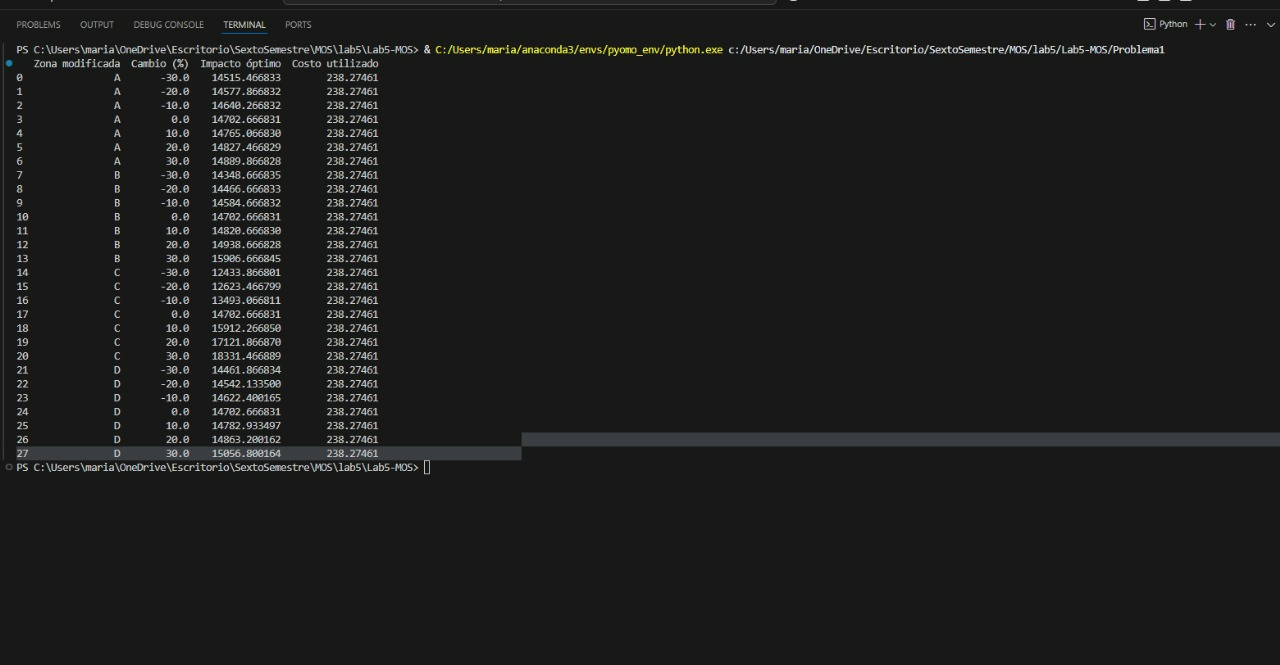

Incluso variando un +-30% cada uno de los multiplicadores de impacto el costo reportado con la solución optima es el mismo. Esto nos lleva a concluir que los multiplicadores de impacto no son un factor decisivo para generar la solucion final ante una varianza alta. Adicionalmente decimos que el modelo es poco sensible a cambios en multiplicadores lo que significa que 

A continuacion se muestran reparticiones de recursos para dos e-constraint-values diferentes, 4500 y 5000 unidades monetarias. Como se observa la repartición de recursos es la misma. Esto se debe a que, como se vio previamente el costo optimo está muy por debajo de estos limites. En el eje y se ve el avion y numero de viaje y en el x, # de recursos.

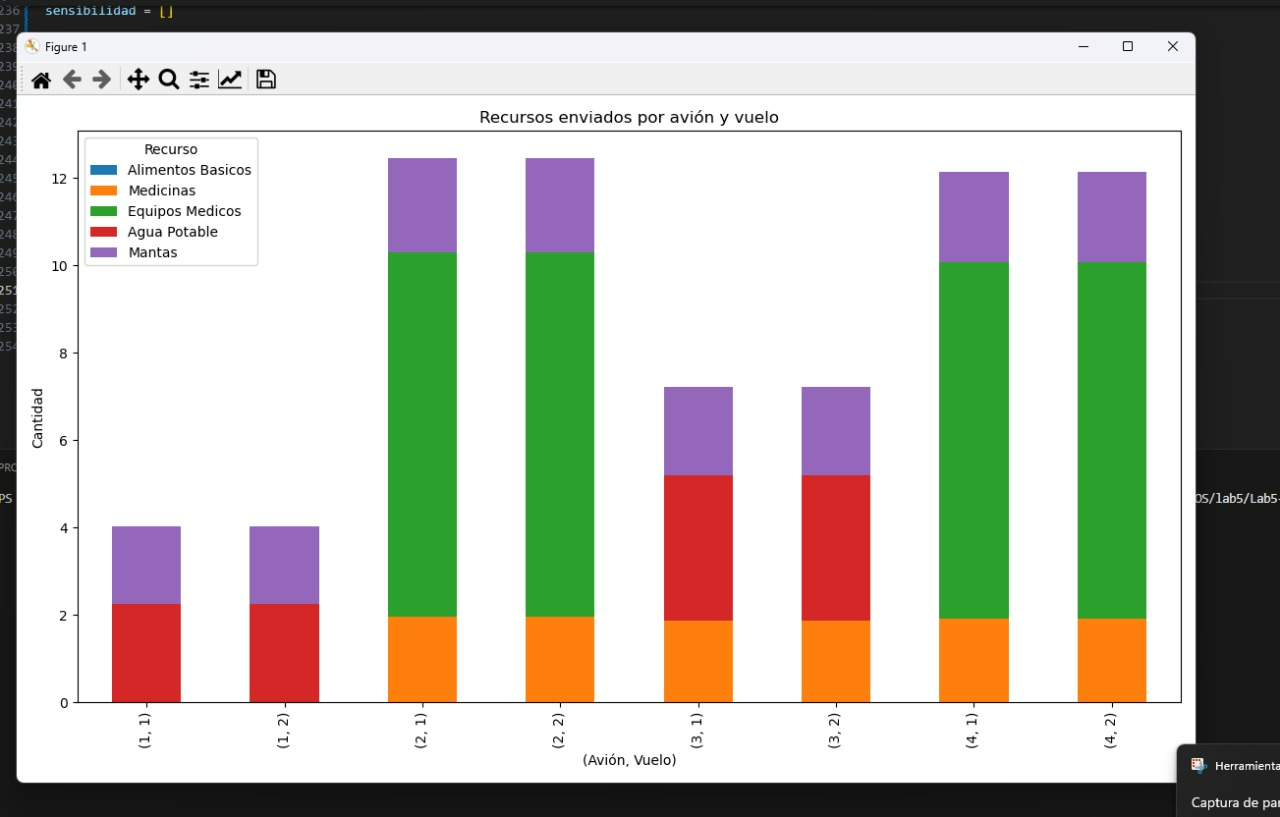

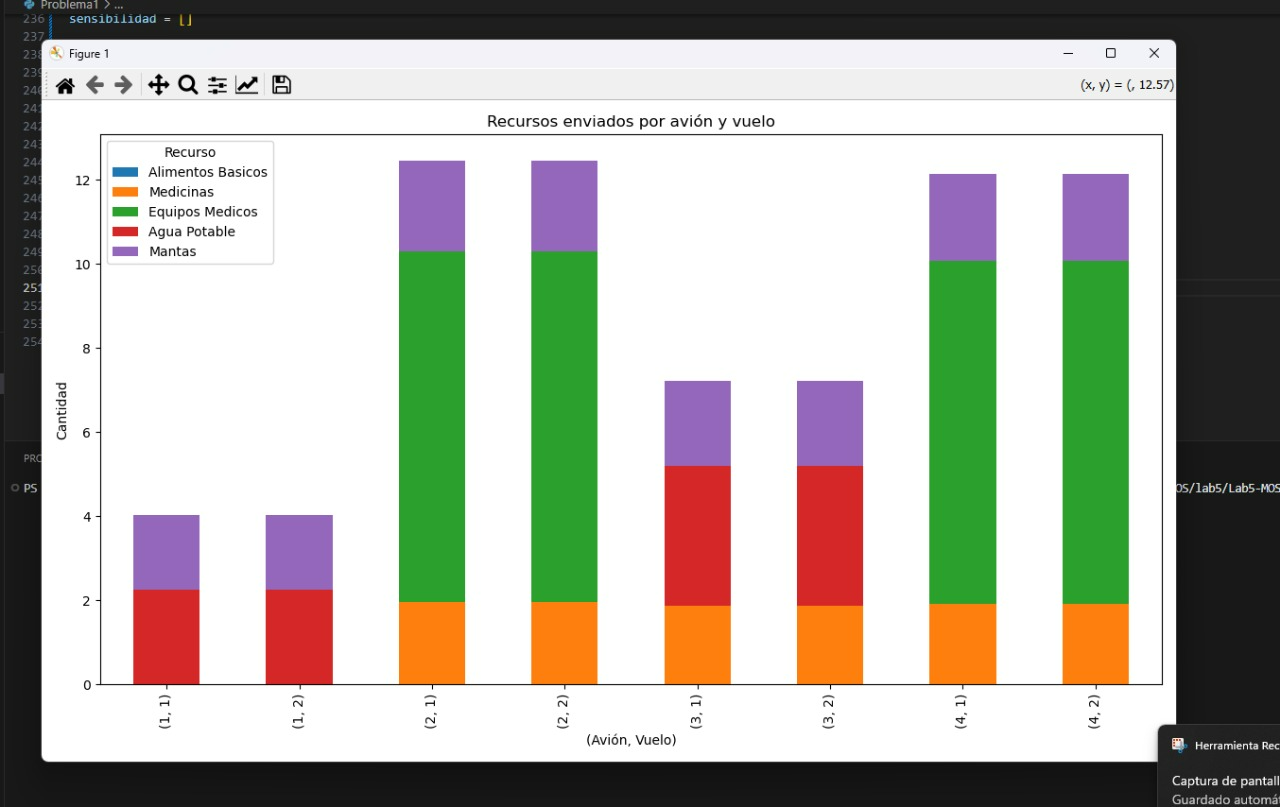